# Chapter10 - LSTM FINAL

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [2]:
df = pd.read_csv("dataset_demand_forecasting_sd.csv")
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


### Timeseries Based

In [3]:
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


In [4]:
len(df)

2547

In [5]:
df['Sales'] = df["Sales"].rolling(window=20).mean()
df = df.dropna()

In [6]:
train = df[df["Date"]< '2018-01-01'].Sales.values.reshape(-1, 1)
test = df[df["Date"]>= '2018-01-01'].Sales.values.reshape(-1, 1)

In [7]:
train

array([[11956.6 ],
       [12030.3 ],
       [11959.45],
       ...,
       [50726.65],
       [51615.5 ],
       [53127.65]])

In [8]:
test

array([[ 53866.45],
       [ 54795.8 ],
       [ 56178.75],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [9]:
ds = df[["Sales"]].values

In [10]:
ds

array([[ 11956.6 ],
       [ 12030.3 ],
       [ 11959.45],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [35]:
train_size = int(len(ds) * 0.75)
test_size = len(ds) - train_size

train = ds[0:train_size,:]
test = ds[train_size:len(ds),:]

In [20]:
print(train.shape)

(1896, 1)


In [21]:
print(test.shape)

(632, 1)


In [39]:
def dataset_generator(df, lookback=0):
    df_x = []
    df_y = []
    
    for i in range(len(df) - lookback - 1):
        tmp = df[i:(i+lookback), 0]
        df_x.append(tmp)
        df_y.append(df[i + lookback, 0])
        
    return np.array(df_x), np.array(df_y)

In [128]:
lookback = 100

X_train, y_train = dataset_generator(train, lookback)
X_test, y_test = dataset_generator(test, lookback)

In [129]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [130]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, look_back)))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1795/1795 - 3s - loss: 0.0031
Epoch 2/10
1795/1795 - 2s - loss: 7.1849e-04
Epoch 3/10
1795/1795 - 2s - loss: 5.4521e-04
Epoch 4/10
1795/1795 - 2s - loss: 4.6728e-04
Epoch 5/10
1795/1795 - 2s - loss: 4.9626e-04
Epoch 6/10
1795/1795 - 2s - loss: 3.7562e-04
Epoch 7/10
1795/1795 - 2s - loss: 3.6596e-04
Epoch 8/10
1795/1795 - 2s - loss: 3.8184e-04
Epoch 9/10
1795/1795 - 2s - loss: 3.0826e-04
Epoch 10/10
1795/1795 - 2s - loss: 3.6573e-04


In [131]:
X_train_forecast = scaler.inverse_transform(model.predict(X_train))
y_train = scaler.inverse_transform([y_train.ravel()])

X_test_forecast = scaler.inverse_transform(model.predict(X_test))
y_test = scaler.inverse_transform([y_test.ravel()])

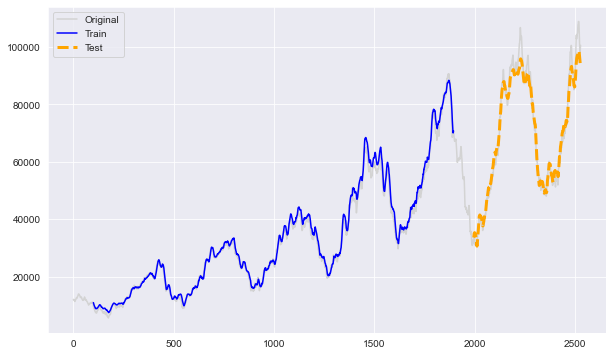

In [166]:
plt.figure(figsize=(10,6))

# Plot original dataset:
plt.plot(list(range(0, len(ds))), scaler.inverse_transform(ds), label="Original", color="lightgrey")

# Plot training data:
train_y_plot = X_train_forecast
train_x_plot = [i+lookback for i in list(range(0, len(X_train_forecast)))]
plt.plot(train_x_plot, train_y_plot , label="Train", color="blue")

# Plot forecasted data:
test_y_plot = X_test_forecast
test_x_plot = [i+lookback*2 for i in list(range(len(X_train_forecast), len(X_train_forecast)+len(X_test_forecast)))]
plt.plot(test_x_plot, test_y_plot , label="Test", color="orange", linewidth=3, linestyle="--")

plt.legend()